<a href="https://colab.research.google.com/github/jhodgens17/audio_classification/blob/main/FSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this notebook is to demonstrate a First Simple Model (FSM) for a speech recognitin model.

In [1]:
#Import packages
import os.path
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
#Read in targets (folders in dataset)
speech_clips = os.listdir('/content/drive/MyDrive/train/audio')

In [3]:
#Checking length of list to verify number of folders
len(speech_clips)

31

Expected number of folders is 31.

In [4]:
#Creating a dictionary to verify the number of audio clips in each folder
clip_dict = {}
for name in speech_clips:
  path = '/content/drive/MyDrive/train/audio/' + name
  num_clips = len(os.listdir(path))
  clip_dict[name] = num_clips

In [5]:
clip_dict

{'_background_noise_': 7,
 'bed': 1713,
 'bird': 1731,
 'cat': 1733,
 'dog': 1746,
 'down': 2359,
 'eight': 2352,
 'five': 2357,
 'four': 2372,
 'go': 2372,
 'happy': 1742,
 'house': 1750,
 'left': 2353,
 'marvin': 1746,
 'nine': 2364,
 'no': 2375,
 'off': 2357,
 'on': 2367,
 'one': 2370,
 'right': 2367,
 'seven': 2377,
 'sheila': 1734,
 'six': 2369,
 'stop': 2380,
 'three': 2356,
 'tree': 1733,
 'two': 2373,
 'up': 2375,
 'wow': 1745,
 'yes': 2377,
 'zero': 2376}

In [6]:
#Check total number of audio clips
total = 0
for clip in clip_dict:
  total = total + clip_dict[clip]

In [7]:
total

64728

Expected nunmber of audio clips is ~65,000.

In [8]:
#Creating a list of the target variables for the kaggle challenge
targets = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']

In [9]:
#Creating a second dictionary to verify the number of clips for the 10 target variables
target_clips = {}
for clip in clip_dict:
  if clip in targets:
    target_clips[clip] = clip_dict[clip]

In [10]:
target_clips

{'down': 2359,
 'go': 2372,
 'left': 2353,
 'no': 2375,
 'off': 2357,
 'on': 2367,
 'right': 2367,
 'stop': 2380,
 'up': 2375,
 'yes': 2377}

In [11]:
#Checking total number of target clips
total_targets = 0
for clip in target_clips:
  total_targets = total_targets + target_clips[clip]

In [12]:
total_targets

23682

Expected 23,682 clips.

The following code explores how to process one audio clip before going through each clip.

In [ ]:
#tensorflow reads in the raw wav file
audio_binary = tf.io.read_file('/content/drive/MyDrive/train/audio/down/00176480_nohash_0.wav')

In [ ]:
#This format is difficult to interpret
audio_binary

<tf.Tensor: shape=(), dtype=string, numpy=b'RIFF$}\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80>\x00\x00\x00}\x00\x00\x02\x00\x10\x00data\x00}\x00\x00\xfb\xff\xfc\xff\xfc\xff\xfb\xff\xfc\xff\xf6\xff\xf1\xff\xfd\xff\x05\x00\x00\x00\xf5\xff\xf8\xff\x02\x00\x07\x00\xf9\xff\xe7\xff\xf7\xff\x03\x00\xfb\xff\xfa\xff\xff\xff\xfa\xff\xf4\xff\x01\x00\x02\x00\xfa\xff\xfb\xff\xfe\xff\x05\x00\x06\x00\x02\x00\x00\x00\x03\x00\r\x00\x04\x00\x02\x00\t\x00\xfc\xff\xf8\xff\x00\x00\xff\xff\xf6\xff\xfb\xff\x07\x00\x03\x00\xf9\xff\xed\xff\xed\xff\xfc\xff\x00\x00\xf6\xff\xfb\xff\x05\x00\xfb\xff\xf7\xff\x03\x00\x02\x00\xf9\xff\xfd\xff\x07\x00\x05\x00\xfe\xff\x00\x00\xff\xff\xff\xff\xff\xff\xf4\xff\xf7\xff\xf6\xff\xf9\xff\x03\x00\xfe\xff\x02\x00\x0b\x00\x06\x00\x02\x00\xff\xff\x00\x00\x01\x00\xfc\xff\xfe\xff\xfd\xff\xf9\xff\x01\x00\x05\x00\x02\x00\x00\x00\xfb\xff\xfb\xff\x01\x00\xfa\xff\xf7\xff\xfc\xff\xf3\xff\xf8\xff\x07\x00\xfd\xff\xf5\xff\xfc\xff\xfa\xff\xf3\xff\xf8\xff\x01\x00\xf8\xff\xf7\xff\x02\x0

In [ ]:
#tensorflow can process this into a more interpretable format
audio, sample_rate = tf.audio.decode_wav(audio_binary)

In [ ]:
#sample_rate is a property of the audio file
sample_rate

<tf.Tensor: shape=(), dtype=int32, numpy=16000>

In [ ]:
#audio contains details about the individual sound file
audio

<tf.Tensor: shape=(16000, 1), dtype=float32, numpy=
array([[-0.00015259],
       [-0.00012207],
       [-0.00012207],
       ...,
       [-0.00027466],
       [-0.00021362],
       [-0.00045776]], dtype=float32)>

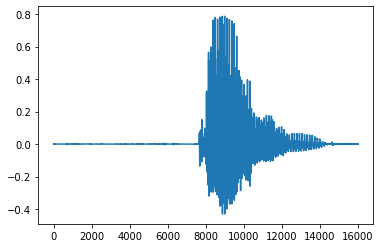

In [ ]:
#This can be plotted visually in what is called the 'waveform' of the sound
plt.plot(audio.numpy())

The first simple model will be a neural network that takes the waveform of a sound clip and identifies if the speaker says 'up' or 'down'.

In [13]:
#Getting a list of files containing audio clips for 'up'
up_files = os.listdir('/content/drive/MyDrive/train/audio/up')

In [14]:
#Getting the full path for the 'up' speech clips
up_paths = []
for file in up_files:
  path = '/content/drive/MyDrive/train/audio/up/' + file
  up_paths.append(path)

In [15]:
#Repeating the process for 'down' clips
down_files = os.listdir('/content/drive/MyDrive/train/audio/down')
down_paths = []
for file in down_files:
  path = '/content/drive/MyDrive/train/audio/down/' + file
  down_paths.append(path)

In [16]:
#Combining all paths
up_and_down_paths = up_paths + down_paths

In [17]:
#Checking length of list to confirm that it equals expected number of files
len(up_and_down_paths)

4734

In [18]:
#Defining function to repeat process to get waveform for each clip
def get_waveform(path):
  audio_binary = tf.io.read_file(path)
  audio, sample_rate = tf.audio.decode_wav(audio_binary)
  waveform = tf.squeeze(audio, axis=-1)
  return waveform

In [19]:
#Getting all of the files
up_files_ds = tf.data.Dataset.from_tensor_slices(up_paths)
down_files_ds = tf.data.Dataset.from_tensor_slices(down_paths)

In [20]:
#Getting the waveform for each file
up_waveform_ds = up_files_ds.map(get_waveform)
down_waveform_ds = down_files_ds.map(get_waveform)

In [21]:
X_list = []
y_list = []
for element in up_waveform_ds:
  if len(element.numpy()) == 16000:
    X_list.append(element.numpy())
    y_list.append(1)

In [22]:
for element in down_waveform_ds:
  if len(element.numpy()) == 16000:
    X_list.append(element.numpy())
    y_list.append(0)

In [23]:
X = np.array(X_list)
y = np.array(y_list)

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [26]:
#Building first simple model
model = Sequential()

In [27]:
model.add(Dense(12, activation='relu', input_dim=16000))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [29]:
model.fit(X_train, y_train, epochs=50, batch_size=10)

Epoch 1/50
316/316 [==============================] - 2s 5ms/step - loss: 0.6975 - accuracy: 0.5070
Epoch 2/50
316/316 [==============================] - 2s 5ms/step - loss: 0.5804 - accuracy: 0.6987
Epoch 3/50
316/316 [==============================] - 2s 6ms/step - loss: 0.4359 - accuracy: 0.8104
Epoch 4/50
316/316 [==============================] - 2s 5ms/step - loss: 0.2929 - accuracy: 0.8896
Epoch 5/50
316/316 [==============================] - 2s 5ms/step - loss: 0.2060 - accuracy: 0.9282
Epoch 6/50
316/316 [==============================] - 2s 5ms/step - loss: 0.1480 - accuracy: 0.9525
Epoch 7/50
316/316 [==============================] - 2s 5ms/step - loss: 0.1092 - accuracy: 0.9712
Epoch 8/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0866 - accuracy: 0.9766
Epoch 9/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0696 - accuracy: 0.9842
Epoch 10/50
316/316 [==============================] - 1s 4ms/step - loss: 0.0482 - accuracy: 0.9877

In [32]:
y_pred = np.argmax(model.predict(X_test), axis = 1)

In [34]:
test_acc = sum(y_pred == y_test) / len(y_test)

In [35]:
test_acc

0.4990512333965844